<a href="https://colab.research.google.com/github/dallinmoore/avalanche-forecasting/blob/main/main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Avalanche Danger

Project by Dallin Moore

---
## Details
Class: DATA 5610 - Deep Learning

Assignment: Final Project

Prof.: Dr. Sharad Jones

In [1]:
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import date
from pathlib import Path
from typing import Dict, List

import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.strtree import STRtree
from shapely.prepared import prep
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors

# CONSTANTS
BASE_URL = "https://wcc.sc.egov.usda.gov/awdbRestApi/services/v1/"


## SNOTEL Data Collection

### Collect Data on Stations

In [78]:
def fetch_snotel_metadata():
    metadata_url = BASE_URL + "stations"
    params = {
        "stationTriplets": "*:UT:SNTL",
        "returnForecastPointMetadata": "false",
        "returnReservoirMetadata": "false",
        "returnStationElements": "false",
        "activeOnly": "true",
        "durations": "HOURLY",
    }
    response = requests.get(metadata_url, params=params, timeout=30)
    if response.ok:
        return response.json()
    print("Request failed with status code:", response.status_code)
    return []

keys = [
    "stationId",
    "stateCode",
    "networkCode",
    "name",
    "countyName",
    "elevation",
    "latitude",
    "longitude",
    "beginDate"
]

data = fetch_snotel_metadata()
snotel_df = pd.DataFrame([{key: station.get(key, "") for key in keys} for station in data])
snotel_df.head()

,stationId,stateCode,networkCode,name,countyName,elevation,latitude,longitude,beginDate
0,907,UT,SNTL,Agua Canyon,Kane,8890.0,37.52217,-112.27118,1994-10-01 00:00
1,1308,UT,SNTL,Atwater,Salt Lake,8750.0,40.59124,-111.63775,2022-08-25 00:00
2,992,UT,SNTL,Bear River RS,Summit,8510.0,40.88520,-110.82770,2010-10-28 00:00
3,329,UT,SNTL,Beaver Dams,Sanpete,7970.0,39.13683,-111.55813,1980-06-18 00:00
4,330,UT,SNTL,Beaver Divide,Summit,8230.0,40.61233,-111.09782,1978-10-01 00:00


### Categorize Stations by Region

In [3]:
region_boundaries = {
    "Logan": [[41.2, -111.9], [42.0, -111.9], [42.0, -111.1], [41.2, -111.1]],
    "Ogden": [[40.8, -112.0], [41.2, -112.0], [41.2, -111.1], [40.8, -111.1]],
    "Salt Lake": [[40.4, -112.0], [40.8, -112.0], [40.8, -111.1], [40.4, -111.1]],
    "Uintas": [[40.3, -111.1], [41.0, -111.1], [41.0, -109.4], [40.3, -109.4]],
    "Provo": [[39.8, -112.0], [40.4, -112.0], [40.4, -111.1], [39.8, -111.1]],
    "Skyline": [[38.9, -111.8], [39.8, -111.8], [39.8, -111.1], [38.9, -111.1]],
    "Moab": [[38.0, -109.8], [39.0, -109.8], [39.0, -108.9], [38.0, -108.9]],
    "Abajos": [[37.5, -109.9], [37.9, -109.9], [37.9, -109.1], [37.5, -109.1]],
    "Southwest": [[37.0, -114.0], [38.5, -114.0], [38.5, -112.5], [37.0, -112.5]],
}

SNOTEL stations that are not in the boundaries, but are within 0.3 degrees (roughly 20 miles) are grouped into that region. So some stations are used by multiple regions and some are not included.

In [79]:
region_shapes = {r: Polygon(c) for r, c in region_boundaries.items()}
_poly_list = list(region_shapes.values())
_region_tree = STRtree(_poly_list)

# Two parallel maps so we handle both pygeos‑style (int indices) *and* Shapely 2.x (clone geoms)
_poly_idx_to_region = {idx: region for idx, region in enumerate(region_shapes)}
_poly_wkb_to_region = {poly.wkb: region for region, poly in region_shapes.items()}

def determine_region(lat, lon, min_distance_threshold=0.1):
    """Return **all** regions whose polygon either contains the point or lies
    within *min_distance_threshold* degrees of it.

    Uses a buffered point when querying the STRtree, so regions whose bounding
    box is within the threshold are considered even if the point itself is
    just outside the box.  Works with both Shapely‑2 (geometries returned) and
    older PyGEOS/Shapely‑1 (integer indices returned).
    """
    pt   = Point(lat, lon)               # (lat, lon) order preserved
    buf  = pt.buffer(min_distance_threshold)  # degrees

    regions = []
    for item in _region_tree.query(buf):  # buffered query widens candidate set
        # Shapely‑1 / PyGEOS ⇒ index; Shapely‑2 ⇒ geometry clone
        if isinstance(item, (int, np.integer)):
            poly   = _poly_list[item]
            region = _poly_idx_to_region[item]
        else:
            poly   = item
            region = _poly_wkb_to_region[poly.wkb]

        if poly.contains(pt) or poly.exterior.distance(pt) <= min_distance_threshold:
            regions.append(region)

    return regions


def map_stations_to_regions(df):
    region_stations = {r: [] for r in region_boundaries}
    for _, row in df.iterrows():
        regs = determine_region(row["latitude"], row["longitude"])
        if not regs:
            continue
        st = {
            "stationId": row["stationId"],
            "name": row["name"],
            "elevation": row["elevation"],
            "latitude": row["latitude"],
            "longitude": row["longitude"],
            "beginDate": row["beginDate"],
        }
        for r in regs:
            region_stations[r].append(st)

    print("SNOTEL Stations mapped to regions:")
    for region, stations in region_stations.items():
        print(f"{region}: {len(stations)} stations")

    return region_stations

region_stations = map_stations_to_regions(snotel_df)

region_stations['Logan'][:5]

SNOTEL Stations mapped to regions:
Logan: 17 stations
Ogden: 13 stations
Salt Lake: 19 stations
Uintas: 29 stations
Provo: 11 stations
Skyline: 18 stations
Moab: 3 stations
Abajos: 3 stations
Southwest: 15 stations


[{'stationId': '332',
  'name': 'Ben Lomond Peak',
  'elevation': 7700.0,
  'latitude': 41.37603,
  'longitude': -111.94405,
  'beginDate': '1978-10-01 00:00'},
 {'stationId': '333',
  'name': 'Ben Lomond Trail',
  'elevation': 5980.0,
  'latitude': 41.38291,
  'longitude': -111.92103,
  'beginDate': '1980-06-03 00:00'},
 {'stationId': '374',
  'name': 'Bug Lake',
  'elevation': 7980.0,
  'latitude': 41.68541,
  'longitude': -111.41987,
  'beginDate': '1978-10-01 00:00'},
 {'stationId': '455',
  'name': 'Dry Bread Pond',
  'elevation': 8290.0,
  'latitude': 41.41289,
  'longitude': -111.5377,
  'beginDate': '1978-10-01 00:00'},
 {'stationId': '1114',
  'name': 'Garden City Summit',
  'elevation': 7680.0,
  'latitude': 41.9215,
  'longitude': -111.4693,
  'beginDate': '2009-10-01 00:00'}]

### Map Each Station to an Elevation Band

Elevation bands are from [Utah Avalanche Center](https://utahavalanchecenter.org/) that are used for their forecasts.

In [5]:
region_elevations = [
  {
    "region": "Logan",
    "elevation_levels": {
      "level_1": {"max": 7000, "min": 0},
      "level_2": {"max": 8500, "min": 7001},
      "level_3": {"max": 20000, "min": 8501}
    }
  },
  {
    "region": "Ogden",
    "elevation_levels": {
      "level_1": {"max": 7000, "min": 0},
      "level_2": {"max": 8500, "min": 7001},
      "level_3": {"max": 20000, "min": 8501}
    }
  },
  {
    "region": "Uintas",
    "elevation_levels": {
      "level_1": {"max": 9500, "min": 0},
      "level_2": {"max": 10000, "min": 9501},
      "level_3": {"max": 20000, "min": 10001}
    }
  },
  {
    "region": "Salt Lake",
    "elevation_levels": {
      "level_1": {"max": 8000, "min": 0},
      "level_2": {"max": 9500, "min": 8001},
      "level_3": {"max": 20000, "min": 9501}
    }
  },
  {
    "region": "Provo",
    "elevation_levels": {
      "level_1": {"max": 8000, "min": 0},
      "level_2": {"max": 9500, "min": 8001},
      "level_3": {"max": 20000, "min": 9501}
    }
  },
  {
    "region": "Skyline",
    "elevation_levels": {
      "level_1": {"max": 8000, "min": 0},
      "level_2": {"max": 9500, "min": 8001},
      "level_3": {"max": 20000, "min": 9501
      }
    }
  }
]

In [80]:
elevation_lookup = {item["region"]: item["elevation_levels"] for item in region_elevations}

def get_elevation_level(elevation, region):
    levels = elevation_lookup.get(region)
    if not levels:
        return 0

    if elevation <= levels["level_1"]["max"]:
        return 1
    if elevation <= levels["level_2"]["max"]:
        return 2
    return 3


for region, stations in region_stations.items():
    for st in stations:
        st["elevation_level"] = get_elevation_level(st["elevation"], region)

print("Sample:")
for region in region_stations:
    print(f"\nRegion: {region}")
    for i, station in enumerate(region_stations[region]):
        print(station)
        # if i < 20:  # Just show first 3 stations as examples
        #     print(f"  Station: {station.get('name', 'Unknown')}, Elevation: {station['elevation']}, Level: {station['elevation_level']}")
    print(f"  ... {len(region_stations[region])} stations total")


Sample:

Region: Logan
{'stationId': '332', 'name': 'Ben Lomond Peak', 'elevation': 7700.0, 'latitude': 41.37603, 'longitude': -111.94405, 'beginDate': '1978-10-01 00:00', 'elevation_level': 2}
{'stationId': '333', 'name': 'Ben Lomond Trail', 'elevation': 5980.0, 'latitude': 41.38291, 'longitude': -111.92103, 'beginDate': '1980-06-03 00:00', 'elevation_level': 1}
{'stationId': '374', 'name': 'Bug Lake', 'elevation': 7980.0, 'latitude': 41.68541, 'longitude': -111.41987, 'beginDate': '1978-10-01 00:00', 'elevation_level': 2}
{'stationId': '455', 'name': 'Dry Bread Pond', 'elevation': 8290.0, 'latitude': 41.41289, 'longitude': -111.5377, 'beginDate': '1978-10-01 00:00', 'elevation_level': 2}
{'stationId': '1114', 'name': 'Garden City Summit', 'elevation': 7680.0, 'latitude': 41.9215, 'longitude': -111.4693, 'beginDate': '2009-10-01 00:00', 'elevation_level': 2}
{'stationId': '533', 'name': 'Horse Ridge', 'elevation': 8210.0, 'latitude': 41.31372, 'longitude': -111.44624, 'beginDate': '19

### Visualize the Stations/Regions

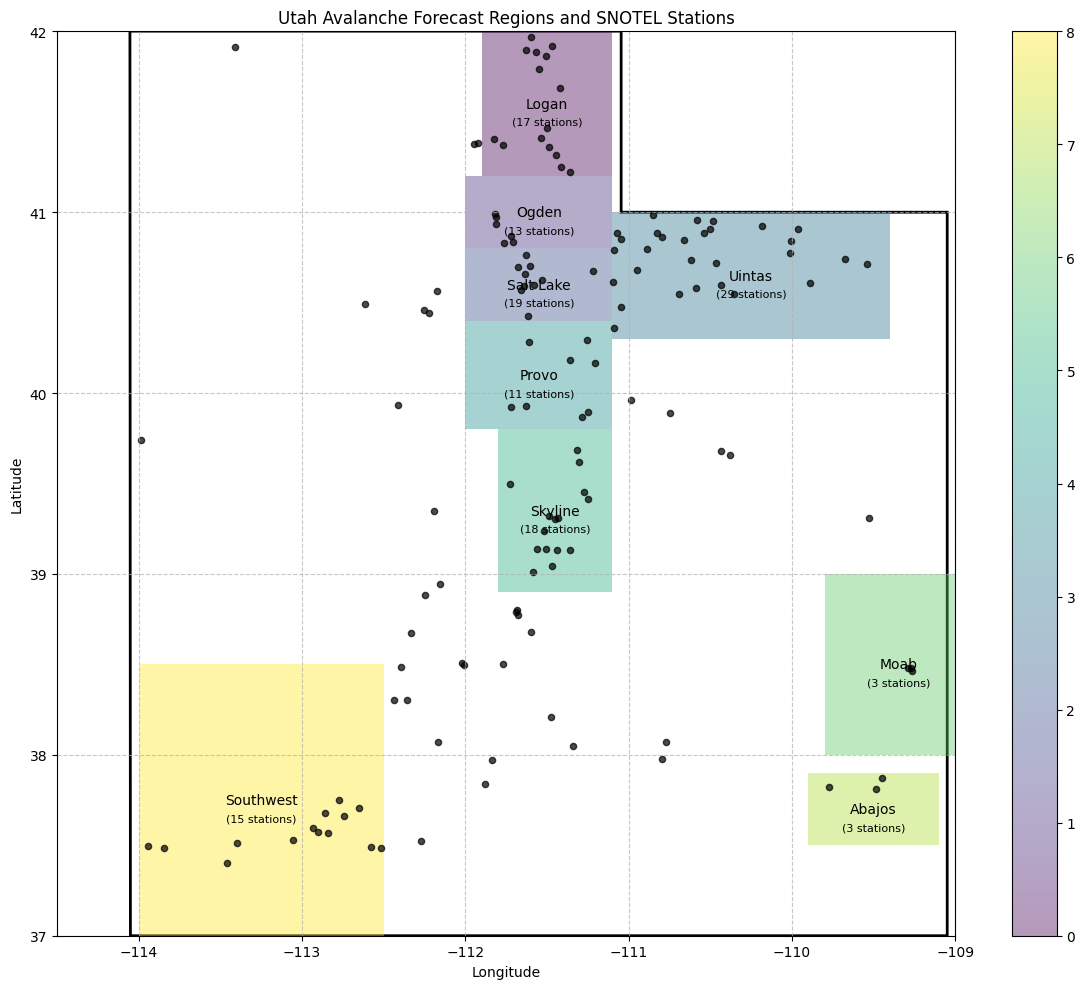

In [7]:
def visualize_regions(snotel_df, region_stations, region_boundaries):
    colors = list(mcolors.TABLEAU_COLORS)

    plt.figure(figsize=(12, 10))
    ax = plt.subplot(111)

    utah_boundary = [
        [42.001, -114.053],
        [42.001, -111.046],
        [41.000, -111.046],
        [41.000, -109.050],
        [37.000, -109.050],
        [37.000, -114.050],
        [42.001, -114.053],
    ]

    utah_coords = np.array(utah_boundary)[:, [1, 0]]
    utah_polygon = MplPolygon(utah_coords, closed=True, fill=False, edgecolor="black", linewidth=2)
    ax.add_patch(utah_polygon)

    patches, region_centroids = [], {}
    for coords in region_boundaries.values():
        patches.append(MplPolygon(np.array(coords)[:, [1, 0]], closed=True, fill=True))

    p = PatchCollection(patches, alpha=0.4)
    p.set_array(np.arange(len(patches)))
    ax.add_collection(p)
    plt.colorbar(p)

    for region_name, coords in region_boundaries.items():
        centroid_x = np.mean([p[1] for p in coords])
        centroid_y = np.mean([p[0] for p in coords])
        region_centroids[region_name] = (centroid_x, centroid_y)
        ax.text(centroid_x, centroid_y, region_name, fontsize=10, ha="center", va="center")

    ax.scatter(snotel_df["longitude"], snotel_df["latitude"], c="black", s=20, alpha=0.7, label="SNOTEL Stations")

    for region_name, (x, y) in region_centroids.items():
        ax.text(x, y - 0.1, f"({len(region_stations[region_name])} stations)", fontsize=8, ha="center", va="center")

    ax.set_xlim(-114.5, -109.0)
    ax.set_ylim(37.0, 42.0)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Utah Avalanche Forecast Regions and SNOTEL Stations")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


visualize_regions(snotel_df, region_stations, region_boundaries)

The boundaries are meant to closely match the map used by the [Utah Avalanche Center](https://utahavalanchecenter.org/). Because there are so few stations in the Abajos and Moab region, and their weather patterns differ significantly from the northern 6 regions, they will be ommited. The Southwest region is being ommited as there are no longer avalanche predictions for it.

In [8]:
regions = ["Logan", "Ogden", "Uintas", "Salt Lake", "Provo", "Skyline"]

In [9]:
def get_unique_station_ids(region_stations, regions):
    return list({st["stationId"] for reg in regions for st in region_stations[reg]})

unique_ids = get_unique_station_ids(region_stations, regions)
len(unique_ids)

86

### Fetch the Timeseries SNOTEL Data

In [10]:
snotel_elements = {
    "Snow_Depth": "SNWD",
    "SWE": "WTEQ",
    "Precipitation_Increment": "PRCP",
    "Snow_Density": "SNDN",
    "Avg_Temp": "TAVG",
    "Max_Temp": "TMAX",
    "Min_Temp": "TMIN",
    "Avg_Wind_Speed": "WSPDV",
    "Max_Wind_Speed": "WSPDX",
    "Avg_Wind_Direction": "WDIRV",
    "Max_Wind_Direction": "WDIRX",
    "Avg_Snow_Temperature": "SNTP",
    "Max_Snow_Temperature": "SNTX",
    "Min_Snow_Temperature": "SNTN",
    "Solar_Radiation": "SRADV",
    "Solar_Radiation_Max": "SRADX",
    "Relative_Humidity": "RHUMV",
    "Max_Relative_Humidity": "RHUMX",
    "Min_Relative_Humidity": "RHUMN",
}

In [11]:
def fetch_snotel_data(triplet, begin_date, end_date, elements):
    data_url = BASE_URL + "data"
    params = {
        "stationTriplets": triplet,
        "beginDate": begin_date,
        "endDate": end_date,
        "elements": ",".join(elements.values()),
        "duration": "DAILY",
    }
    for _ in range(2):
        try:
            resp = requests.get(data_url, params=params, timeout=60)
            if resp.ok:
                return resp.json()
        except Exception as e:
            print(f"Retrying {triplet} after error: {e}")
    print("Failed:", triplet)
    return []


def process_station_data(station_id, start_date, end_date, elements):
    triplet = f"{station_id}:UT:SNTL"
    series = []
    for site in fetch_snotel_data(triplet, start_date, end_date, elements):
        for element in site.get("data", []):
            code = element["stationElement"]["elementCode"]
            col = next(k for k, v in elements.items() if v == code)
            for val in element.get("values", []):
                rec = next((r for r in series if r["Date"] == val["date"]), None)
                if rec is None:
                    rec = {"Date": val["date"], "stationId": station_id}
                    series.append(rec)
                rec[col] = val.get("value")
    return series


def fetch_all_snotel_data( ids, elements, start_date, end_date=date.today().strftime("%Y-%m-%d"), max_workers=15,):
    total = len(ids)
    print(f"Fetching daily SNOTEL data for {total} stations…")

    all_rows = []
    done = 0

    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures = {
            ex.submit(process_station_data, sid, start_date, end_date, elements): sid
            for sid in ids
        }

        for fut in as_completed(futures):
            sid = futures[fut]
            try:
                all_rows.extend(fut.result())
            except Exception as e:
                # keep going, but show which station failed
                print(f"  ✖ {sid} → {e}")
            done += 1

            # Print progress every 10 stations or on the last one
            if done % 10 == 0 or done == total:
                print(f"  {done}/{total} stations complete ({done / total:.0%})")

    return pd.DataFrame(all_rows)



snotel_df_ts = fetch_all_snotel_data(unique_ids, snotel_elements, "2013-12-13")
snotel_df_ts.head()

Fetching daily SNOTEL data for 86 stations…
  10/86 stations complete (12%)
  20/86 stations complete (23%)
  30/86 stations complete (35%)
  40/86 stations complete (47%)
  50/86 stations complete (58%)
  60/86 stations complete (70%)
  70/86 stations complete (81%)
  80/86 stations complete (93%)
  86/86 stations complete (100%)


,Date,stationId,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
0,2022-08-25,1308,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-08-26,1308,0.1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-08-27,1308,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-08-28,1308,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-08-29,1308,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
snotel_df_ts.describe()

,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
count,341801.000000,341878.000000,341884.000000,340434.000000,340459.000000,340374.000000,170542.000000,12741.000000,12737.000000,12737.000000
mean,0.086293,17.287345,5.342880,39.155369,50.798576,28.644529,29.428554,218.736441,5.013300,17.102842
std,0.215686,23.086133,8.151401,16.237940,17.614966,15.810329,9.052990,285.481407,3.847713,7.222232
min,0.000000,0.000000,0.000000,-147.800000,-147.800000,-147.800000,6.200000,-100.000000,-99.900000,-99.900000
25%,0.000000,0.000000,0.000000,26.800000,36.900000,17.400000,22.800000,140.000000,2.700000,12.200000
50%,0.000000,4.000000,0.900000,37.900000,49.500000,28.800000,27.800000,242.000000,3.400000,15.700000
75%,0.100000,31.000000,8.400000,53.100000,65.800000,41.000000,35.100000,284.000000,6.200000,21.000000
max,5.700000,229.000000,82.800000,83.700000,132.100000,83.700000,85.000000,18922.000000,26.100000,56.800000


In [13]:
snotel_df_ts[snotel_df_ts["Avg_Wind_Speed"] <= -99]

,Date,stationId,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
104621,2024-12-04,828,0.0,20.0,4.4,NaN,NaN,NaN,22.0,-100.0,-99.9,-99.9


There appears to be a bad wind reading at station 828 on 2024-12-04.

In [14]:
# Identify the rows you want to modify
mask = (snotel_df_ts["Avg_Wind_Speed"] <= -99)

# Set specific columns to NaN
snotel_df_ts.loc[mask, ["Avg_Wind_Direction", "Avg_Wind_Speed", "Max_Wind_Speed"]] = np.nan
snotel_df_ts.describe()

,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
count,341801.000000,341878.000000,341884.000000,340434.000000,340459.000000,340374.000000,170542.000000,12740.000000,12736.000000,12736.000000
mean,0.086293,17.287345,5.342880,39.155369,50.798576,28.644529,29.428554,218.761460,5.021537,17.112029
std,0.215686,23.086133,8.151401,16.237940,17.614966,15.810329,9.052990,285.478644,3.733858,7.147704
min,0.000000,0.000000,0.000000,-147.800000,-147.800000,-147.800000,6.200000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,26.800000,36.900000,17.400000,22.800000,140.000000,2.700000,12.200000
50%,0.000000,4.000000,0.900000,37.900000,49.500000,28.800000,27.800000,242.000000,3.400000,15.700000
75%,0.100000,31.000000,8.400000,53.100000,65.800000,41.000000,35.100000,284.000000,6.200000,21.000000
max,5.700000,229.000000,82.800000,83.700000,132.100000,83.700000,85.000000,18922.000000,26.100000,56.800000


In [15]:
len(snotel_df_ts)

341884

### Combine the Datasets

In [53]:
snotel_dataset = pd.merge(snotel_df_ts, snotel_df, on="stationId", how="left")
snotel_dataset.head()

,Date,stationId,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed,stateCode,networkCode,name,countyName,elevation,latitude,longitude
0,2022-08-25,1308,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UT,SNTL,Atwater,Salt Lake,8750.0,40.59124,-111.63775
1,2022-08-26,1308,0.1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UT,SNTL,Atwater,Salt Lake,8750.0,40.59124,-111.63775
2,2022-08-27,1308,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UT,SNTL,Atwater,Salt Lake,8750.0,40.59124,-111.63775
3,2022-08-28,1308,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UT,SNTL,Atwater,Salt Lake,8750.0,40.59124,-111.63775
4,2022-08-29,1308,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UT,SNTL,Atwater,Salt Lake,8750.0,40.59124,-111.63775


In [54]:
def process_snotel_data(snotel_df: pd.DataFrame, region_stations: dict) -> pd.DataFrame:
    # Build fast lookup
    lookup = {
        reg: {st["stationId"]: st for st in stations}
        for reg, stations in region_stations.items()
    }

    # Expand rows with Region and elevation_level
    new_rows = []
    for _, row in snotel_df.iterrows():
        st_id = row["stationId"]
        regions = [r for r, d in lookup.items() if st_id in d] or ["Unknown"]
        for reg in regions:
            rec = row.to_dict().copy()
            rec["Region"] = reg
            if reg != "Unknown":
                rec["elevation_level"] = lookup[reg][st_id].get("elevation_level", "Unknown")
            else:
                rec["elevation_level"] = "Unknown"
            new_rows.append(rec)

    df_expanded = pd.DataFrame(new_rows)

    # Handle metadata columns
    metadata = [
        "Region", "stationId", "elevation_level",
        "Date", "name", "stateCode", "networkCode",
        "countyName", "elevation", "latitude", "longitude"
    ]
    metadata = [col for col in metadata if col in df_expanded.columns]

    # Identify if wind direction exists
    if "Avg_Wind_Direction" in df_expanded.columns:
        # Calculate u and v components
        wind_dir_rad = np.deg2rad(df_expanded["Avg_Wind_Direction"])
        df_expanded["wind_u"] = -np.sin(wind_dir_rad)
        df_expanded["wind_v"] = -np.cos(wind_dir_rad)

        # Average u and v across any duplicate station/date if needed
        # (Right now, you're not grouping. If you group later, you can use these.)

        # Compute the new average wind direction
        avg_u = df_expanded["wind_u"]
        avg_v = df_expanded["wind_v"]
        mean_dir_rad = np.arctan2(avg_u, avg_v)
        mean_dir_deg = (np.rad2deg(mean_dir_rad) + 360) % 360  # Normalize between 0–360

        # Replace the Avg_Wind_Direction with the corrected vector-averaged direction
        df_expanded["Avg_Wind_Direction"] = mean_dir_deg

        # Drop helper columns
        df_expanded.drop(columns=["wind_u", "wind_v"], inplace=True)

    elements = [col for col in df_expanded.columns if col not in metadata]

    return df_expanded[metadata + elements]


snotel_dataset = process_snotel_data(snotel_dataset, region_stations)
snotel_dataset.head()

,Region,stationId,elevation_level,Date,name,stateCode,networkCode,countyName,elevation,latitude,...,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
0,Salt Lake,1308,2,2022-08-25,Atwater,UT,SNTL,Salt Lake,8750.0,40.59124,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Salt Lake,1308,2,2022-08-26,Atwater,UT,SNTL,Salt Lake,8750.0,40.59124,...,0.1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Salt Lake,1308,2,2022-08-27,Atwater,UT,SNTL,Salt Lake,8750.0,40.59124,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Salt Lake,1308,2,2022-08-28,Atwater,UT,SNTL,Salt Lake,8750.0,40.59124,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Salt Lake,1308,2,2022-08-29,Atwater,UT,SNTL,Salt Lake,8750.0,40.59124,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
snotel_dataset.describe()

,elevation_level,elevation,latitude,longitude,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
count,422141.000000,422141.000000,422141.000000,422141.000000,421946.000000,422133.000000,422141.000000,420364.000000,420398.000000,420313.000000,209173.000000,15473.000000,15469.000000,15469.000000
mean,1.689128,8439.701285,40.585687,-111.212860,0.085820,17.125022,5.274888,39.363830,51.022054,28.894200,29.415874,162.442836,4.620712,16.270095
std,0.703064,1044.640240,0.721535,0.517238,0.213991,22.854886,8.006246,16.194066,17.694893,15.656788,9.040245,102.625032,3.510189,6.986834
min,1.000000,5980.000000,38.800340,-111.944050,0.000000,0.000000,0.000000,-147.800000,-147.800000,-147.800000,6.200000,0.000000,0.000000,0.000000
25%,1.000000,7830.000000,40.295300,-111.597130,0.000000,0.000000,0.000000,27.000000,37.000000,17.800000,22.800000,82.000000,2.600000,11.500000
50%,2.000000,8230.000000,40.761840,-111.359470,0.000000,4.000000,0.800000,38.100000,49.600000,29.100000,27.800000,119.000000,3.200000,14.900000
75%,2.000000,9160.000000,40.908620,-111.047650,0.100000,31.000000,8.400000,53.200000,66.200000,41.200000,35.100000,273.000000,5.300000,19.800000
max,3.000000,10920.000000,41.967690,-109.544010,5.700000,229.000000,82.800000,83.700000,132.100000,83.700000,85.000000,359.000000,26.100000,56.800000


In [56]:
snotel_dataset = snotel_dataset[snotel_dataset["Avg_Wind_Speed"] >= 0]

snotel_dataset["Region"].value_counts()

,count
Region,
Ogden,4448
Provo,4136
Skyline,4008
Salt Lake,2733
Uintas,144


There are only a few stations that provide wind data, but given that this is data is freely and easily accessible, I will ommit the Logan Region as there is not a station with wind data instead of gathering other data (which I have considered from sources like NOAA, MesoNet, ERA5).

In [57]:
regions = ["Ogden", "Uintas", "Salt Lake", "Provo", "Skyline"]

In [58]:
snotel_dataset.sort_values(["Date", "elevation_level", "Region"], inplace=True)
snotel_dataset

,Region,stationId,elevation_level,Date,name,stateCode,networkCode,countyName,elevation,latitude,...,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
218255,Ogden,972,1,2013-12-13,Louis Meadow,UT,SNTL,Salt Lake,6750.0,40.83033,...,0.0,16.0,4.0,16.3,26.4,9.9,25.0,261.0,2.3,9.3
218256,Salt Lake,972,1,2013-12-13,Louis Meadow,UT,SNTL,Salt Lake,6750.0,40.83033,...,0.0,16.0,4.0,16.3,26.4,9.9,25.0,261.0,2.3,9.3
155945,Provo,435,2,2013-12-13,Daniels-Strawberry,UT,SNTL,Wasatch,8010.0,40.29530,...,0.1,15.0,2.1,23.5,29.8,18.0,14.0,137.0,4.9,19.3
226563,Skyline,742,3,2013-12-13,Seeley Creek,UT,SNTL,Sanpete,9900.0,39.31042,...,0.0,16.0,4.6,18.9,27.9,14.0,28.8,118.0,15.5,28.2
218257,Ogden,972,1,2013-12-14,Louis Meadow,UT,SNTL,Salt Lake,6750.0,40.83033,...,0.0,15.0,4.0,18.3,27.1,8.6,26.7,242.0,2.0,7.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230715,Skyline,742,3,2025-04-26,Seeley Creek,UT,SNTL,Sanpete,9900.0,39.31042,...,0.0,16.0,6.3,40.1,47.3,30.9,39.4,340.0,5.8,17.1
372292,Ogden,971,2,2025-04-27,Parrish Creek,UT,SNTL,Davis,7760.0,40.93417,...,0.0,26.0,11.2,39.6,47.1,32.5,43.1,358.0,0.0,3.5
160098,Provo,435,2,2025-04-27,Daniels-Strawberry,UT,SNTL,Wasatch,8010.0,40.29530,...,0.0,0.0,0.0,36.5,46.2,28.6,NaN,49.0,2.9,14.7
131020,Uintas,828,2,2025-04-27,Trial Lake,UT,SNTL,Summit,9970.0,40.67800,...,0.0,47.0,20.7,28.8,39.4,16.2,44.0,339.0,1.1,13.2


### Aggregate the Data For Each Region, Elevation Level, and Day

In [59]:
# Ensure Date is a datetime and sort
snotel_dataset.loc[:, 'Date'] = pd.to_datetime(snotel_dataset['Date'])
snotel_dataset = snotel_dataset.sort_values(['Region', 'elevation_level', 'Date'])
snotel_dataset.head()

,Region,stationId,elevation_level,Date,name,stateCode,networkCode,countyName,elevation,latitude,...,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
218255,Ogden,972,1,2013-12-13 00:00:00,Louis Meadow,UT,SNTL,Salt Lake,6750.0,40.83033,...,0.0,16.0,4.0,16.3,26.4,9.9,25.0,261.0,2.3,9.3
218257,Ogden,972,1,2013-12-14 00:00:00,Louis Meadow,UT,SNTL,Salt Lake,6750.0,40.83033,...,0.0,15.0,4.0,18.3,27.1,8.6,26.7,242.0,2.0,7.8
218259,Ogden,972,1,2013-12-15 00:00:00,Louis Meadow,UT,SNTL,Salt Lake,6750.0,40.83033,...,0.1,15.0,4.1,18.7,26.4,12.7,27.3,274.0,3.0,6.0
218261,Ogden,972,1,2013-12-16 00:00:00,Louis Meadow,UT,SNTL,Salt Lake,6750.0,40.83033,...,0.0,15.0,4.1,23.0,28.8,18.3,27.3,268.0,3.6,5.5
218263,Ogden,972,1,2013-12-17 00:00:00,Louis Meadow,UT,SNTL,Salt Lake,6750.0,40.83033,...,0.0,15.0,4.1,25.2,30.0,19.8,27.3,272.0,3.8,6.7


In [60]:
# Define which columns to aggregate and how
agg_map = {
    'Precipitation_Increment': 'max',
    'Snow_Depth':            'max',
    'SWE':                   'max',
    'Avg_Temp':              'mean',
    'Max_Temp':              'max',
    'Min_Temp':              'min',
    'Snow_Density':          'mean',
    'Avg_Wind_Direction':    'max', # while not ideal, there are not multiple stations in any of the regions but max w
    'Avg_Wind_Speed':        'mean',
    'Max_Wind_Speed':        'max'
}

# Perform the aggregation
snotel_dataset_agg = (
    snotel_dataset
    .groupby(['Region', 'elevation_level', 'Date'], as_index=False)
    .agg(agg_map)
)

snotel_dataset_agg.head()

,Region,elevation_level,Date,Precipitation_Increment,Snow_Depth,SWE,Avg_Temp,Max_Temp,Min_Temp,Snow_Density,Avg_Wind_Direction,Avg_Wind_Speed,Max_Wind_Speed
0,Ogden,1,2013-12-13,0.0,16.0,4.0,16.3,26.4,9.9,25.0,261.0,2.3,9.3
1,Ogden,1,2013-12-14,0.0,15.0,4.0,18.3,27.1,8.6,26.7,242.0,2.0,7.8
2,Ogden,1,2013-12-15,0.1,15.0,4.1,18.7,26.4,12.7,27.3,274.0,3.0,6.0
3,Ogden,1,2013-12-16,0.0,15.0,4.1,23.0,28.8,18.3,27.3,268.0,3.6,5.5
4,Ogden,1,2013-12-17,0.0,15.0,4.1,25.2,30.0,19.8,27.3,272.0,3.8,6.7


In [62]:
import pandas as pd
import numpy as np

# List of all regions and elevation levels
regions = ["Logan", "Ogden", "Uintas", "Salt Lake", "Provo", "Skyline"]
elevation_levels = [1, 2, 3]
to_fill = list(agg_map.keys())

# Step 1: Create a complete index with all combinations
dates = snotel_dataset_agg['Date'].unique()
multi_index = pd.MultiIndex.from_product(
    [regions, dates, elevation_levels],
    names=['Region', 'Date', 'elevation_level']
)

# Step 2: Create a complete DataFrame with all combinations
complete_df = pd.DataFrame(index=multi_index).reset_index()

# Step 3: Merge with the original data
merged_df = pd.merge(
    complete_df,
    snotel_dataset_agg,
    on=['Region', 'Date', 'elevation_level'],
    how='left'
)

# Step 4: Reshape the data for efficient processing
# Create a pivot table with Region, Date as index and elevation_level as columns
pivot_df = merged_df.pivot_table(
    index=['Region', 'Date'],
    columns='elevation_level',
    values=to_fill
)

# Step 5: Apply the filling logic for each column efficiently
for col in to_fill:
    col_data = pivot_df[col]

    # Make a copy to avoid SettingWithCopyWarning
    col_data_filled = col_data.copy()

    # First fill elevation level 2 from average of 1 and 3 where both exist
    mask_avg = pd.isna(col_data[2]) & ~pd.isna(col_data[1]) & ~pd.isna(col_data[3])
    col_data_filled.loc[mask_avg, 2] = (col_data.loc[mask_avg, 1] + col_data.loc[mask_avg, 3]) / 2

    # Then fill elevation level 2 from 1 or 3
    mask_from1 = pd.isna(col_data_filled[2]) & ~pd.isna(col_data[1])
    col_data_filled.loc[mask_from1, 2] = col_data.loc[mask_from1, 1]

    mask_from3 = pd.isna(col_data_filled[2]) & ~pd.isna(col_data[3])
    col_data_filled.loc[mask_from3, 2] = col_data.loc[mask_from3, 3]

    # Fill elevation level 3 from 2 or 1
    mask_3from2 = pd.isna(col_data[3]) & ~pd.isna(col_data_filled[2])
    col_data_filled.loc[mask_3from2, 3] = col_data_filled.loc[mask_3from2, 2]

    mask_3from1 = pd.isna(col_data_filled[3]) & ~pd.isna(col_data[1])
    col_data_filled.loc[mask_3from1, 3] = col_data.loc[mask_3from1, 1]

    # Fill elevation level 1 from 2 or 3
    mask_1from2 = pd.isna(col_data[1]) & ~pd.isna(col_data_filled[2])
    col_data_filled.loc[mask_1from2, 1] = col_data_filled.loc[mask_1from2, 2]

    mask_1from3 = pd.isna(col_data_filled[1]) & ~pd.isna(col_data_filled[3])
    col_data_filled.loc[mask_1from3, 1] = col_data_filled.loc[mask_1from3, 3]

    # Update the pivot table
    pivot_df[col] = col_data_filled

# Step 6: Reshape back to the original format
# Stack to convert from wide to long format
filled_long = pivot_df.stack().reset_index()
filled_long.rename(columns={'level_2': 'elevation_level'}, inplace=True)

# Convert column multi-index to single level
# This handles the fact that we now have multi-level column names like (snow_depth, 1)
filled_long_flat = filled_long.copy()
filled_long_flat.columns = [col[0] if isinstance(col, tuple) else col for col in filled_long_flat.columns]

# Step 7: Fill any remaining missing values with region means
overall_means = filled_long_flat.groupby('Region')[to_fill].transform('mean')
filled_long_flat[to_fill] = filled_long_flat[to_fill].fillna(overall_means)

# Replace the original aggregated dataset
snotel_dataset_agg = filled_long_flat

# Check the results
snotel_dataset_agg.head()

<ipython-input-62-dcf98c4e17a7>:72: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  filled_long = pivot_df.stack().reset_index()


,Region,Date,elevation_level,Avg_Temp,Avg_Wind_Direction,Avg_Wind_Speed,Max_Temp,Max_Wind_Speed,Min_Temp,Precipitation_Increment,SWE,Snow_Density,Snow_Depth
0,Ogden,2013-12-13,1,16.3,261.0,2.3,26.4,9.3,9.9,0.0,4.0,25.0,16.0
1,Ogden,2013-12-13,2,16.3,261.0,2.3,26.4,9.3,9.9,0.0,4.0,25.0,16.0
2,Ogden,2013-12-13,3,16.3,261.0,2.3,26.4,9.3,9.9,0.0,4.0,25.0,16.0
3,Ogden,2013-12-14,1,18.3,242.0,2.0,27.1,7.8,8.6,0.0,4.0,26.7,15.0
4,Ogden,2013-12-14,2,18.3,242.0,2.0,27.1,7.8,8.6,0.0,4.0,26.7,15.0


In [63]:
snotel_dataset_agg.to_csv("snotel_dataset_agg.csv", index=False)

In [64]:
snotel_dataset_agg = pd.read_csv("snotel_dataset_agg.csv")

## Read Avalanch Forecast Dataset

In [65]:
avy_forecast_df = pd.read_csv("avalanche-forecast-rose.csv")
avy_forecast_df.head()

,Date Issued,Forecast Area,Link,North-lower,Northeast-lower,East-lower,Southeast-lower,South-lower,Southwest-lower,West-lower,...,West-middle,Northwest-middle,North-upper,Northeast-upper,East-upper,Southeast-upper,South-upper,Southwest-upper,West-upper,Northwest-upper
0,3/7/2024,Provo,https://utahavalanchecenter.org/forecast/provo...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,3/7/2024,Moab,https://utahavalanchecenter.org/forecast/moab/...,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0
2,3/7/2024,Ogden,https://utahavalanchecenter.org/forecast/ogden...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,3/7/2024,Logan,https://utahavalanchecenter.org/forecast/logan...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,3/7/2024,Skyline,https://utahavalanchecenter.org/forecast/skyli...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0


In [66]:
avy_forecast_df = avy_forecast_df.rename(columns={"Forecast Area": "Region", "Date Issued": "Date"})
avy_forecast_df.head()

,Date,Region,Link,North-lower,Northeast-lower,East-lower,Southeast-lower,South-lower,Southwest-lower,West-lower,...,West-middle,Northwest-middle,North-upper,Northeast-upper,East-upper,Southeast-upper,South-upper,Southwest-upper,West-upper,Northwest-upper
0,3/7/2024,Provo,https://utahavalanchecenter.org/forecast/provo...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,3/7/2024,Moab,https://utahavalanchecenter.org/forecast/moab/...,2.0,2.0,2.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0
2,3/7/2024,Ogden,https://utahavalanchecenter.org/forecast/ogden...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,3/7/2024,Logan,https://utahavalanchecenter.org/forecast/logan...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,3/7/2024,Skyline,https://utahavalanchecenter.org/forecast/skyli...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0


In [67]:
# Drop unused regions
avy_forecast_df = avy_forecast_df[avy_forecast_df["Region"].isin(regions)]
set(avy_forecast_df['Region'])

{'Logan', 'Ogden', 'Provo', 'Salt Lake', 'Skyline', 'Uintas'}

In [68]:
avy_forecast_df.loc[:, "Date"] = pd.to_datetime(avy_forecast_df["Date"])


In [69]:
id_cols = ['Date', 'Region']
level_codes = {'lower': 1, 'middle': 2, 'upper': 3}


In [70]:
pieces = []
for lvl in level_codes:
    # find all columns that end with "-<lvl>"
    lvl_cols = [c for c in avy_forecast_df.columns if c.endswith(f'-{lvl}')]
    # select id_cols + those columns
    sub = avy_forecast_df[id_cols + lvl_cols].copy()
    # rename e.g. "North-lower" → "North"
    rename_map = {c: c.rsplit('-', 1)[0] for c in lvl_cols}
    sub = sub.rename(columns=rename_map)
    # tag the numeric elevation_level
    sub['elevation_level'] = level_codes[lvl]
    pieces.append(sub)

# 5) Concatenate back into one “long” DataFrame
avy_forecast_long = pd.concat(pieces, ignore_index=True)
avy_forecast_long.head()

,Date,Region,North,Northeast,East,Southeast,South,Southwest,West,Northwest,elevation_level
0,2024-03-07 00:00:00,Provo,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
1,2024-03-07 00:00:00,Ogden,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,2024-03-07 00:00:00,Logan,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,2024-03-07 00:00:00,Skyline,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
4,2024-03-07 00:00:00,Salt Lake,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1


In [71]:
avy_forecast_long.to_csv("avy_forecast_long.csv", index=False)

In [72]:
avy_forecast_long['Date'] = pd.to_datetime(avy_forecast_long['Date']).dt.normalize()
snotel_dataset_agg['Date'] = pd.to_datetime(snotel_dataset_agg['Date']).dt.normalize()

In [73]:
combined_df = pd.merge(avy_forecast_long, snotel_dataset_agg, on=["Date","Region","elevation_level"], how="left")
combined_df.sort_values(["Date", "elevation_level", "Region"], inplace=True)
combined_df.head()

,Date,Region,North,Northeast,East,Southeast,South,Southwest,West,Northwest,...,Avg_Temp,Avg_Wind_Direction,Avg_Wind_Speed,Max_Temp,Max_Wind_Speed,Min_Temp,Precipitation_Increment,SWE,Snow_Density,Snow_Depth
8847,2013-12-13,Logan,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8846,2013-12-13,Ogden,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,16.3,261.0,2.3,26.4,9.3,9.9,0.0,4.0,25.0,16.0
8845,2013-12-13,Provo,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,23.5,137.0,4.9,29.8,19.3,18.0,0.1,2.1,14.0,15.0
8844,2013-12-13,Salt Lake,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,16.3,261.0,2.3,26.4,9.3,9.9,0.0,4.0,25.0,16.0
8843,2013-12-13,Skyline,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,18.9,118.0,15.5,27.9,28.2,14.0,0.0,4.6,28.8,16.0


In [76]:
combined_df[combined_df[to_fill].isna().any(axis=1)]

,Date,Region,North,Northeast,East,Southeast,South,Southwest,West,Northwest,...,Avg_Temp,Avg_Wind_Direction,Avg_Wind_Speed,Max_Temp,Max_Wind_Speed,Min_Temp,Precipitation_Increment,SWE,Snow_Density,Snow_Depth
8847,2013-12-13,Logan,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18880,2013-12-13,Logan,2.0,2.0,2.0,1.0,1.0,1.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28913,2013-12-13,Logan,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8842,2013-12-14,Logan,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8838,2013-12-14,Uintas,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19998,2025-04-17,Salt Lake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30031,2025-04-17,Salt Lake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9959,2025-04-18,Salt Lake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19992,2025-04-18,Salt Lake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Create a Transformer

In [75]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)  # e.g. 3 folds
for fold, (train_index, val_index) in enumerate(tscv.split(final_df), 1):
    train_df = final_df.iloc[train_index]
    val_df   = final_df.iloc[val_index]
    print(f"Fold {fold}: train up to {train_df.Date.max()}, validate up to {val_df.Date.max()}")


NameError: name 'final_df' is not defined

In [ ]:
import torch

X_train = torch.from_numpy(train_df[weather_features].values).float()
Y_train = torch.from_numpy(train_df[target_cols].values).long()  # or float()

from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=False)


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch

X_tensor = torch.tensor(X.values, dtype=torch.float32)    # (N, F)
Y_tensor = torch.tensor(Y.values, dtype=torch.long)       # (N, 24)
ds = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(ds, batch_size=32, shuffle=True)


In [ ]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=24):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, 24, d_model)

    def forward(self, x):
        # x: (batch, 24, d_model)
        return x + self.pe

class ForecastTransformer(nn.Module):
    def __init__(self, feature_dim, token_embed_dim=64, n_heads=4, n_layers=2, num_classes=5):
        super().__init__()
        # learnable embedding for each of the 24 positions (aspect × elevation)
        self.token_emb = nn.Embedding(24, token_embed_dim)
        # project global features into same dim
        self.feature_proj = nn.Linear(feature_dim, token_embed_dim)
        # positional encoding
        self.pos_enc = PositionalEncoding(token_embed_dim, max_len=24)
        # transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=token_embed_dim,
            nhead=n_heads,
            dim_feedforward=token_embed_dim * 4,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        # classification head per token
        self.classifier = nn.Linear(token_embed_dim, num_classes)

    def forward(self, features):
        """
        features: (batch, feature_dim)
        returns logits of shape (batch, 24, num_classes)
        """
        bsz = features.size(0)
        # repeat feature vector for each of the 24 tokens
        feat = self.feature_proj(features).unsqueeze(1).repeat(1, 24, 1)  # (b,24,d)
        # token embeddings
        token_ids = torch.arange(24, device=features.device).unsqueeze(0).repeat(bsz,1)
        tok = self.token_emb(token_ids)                                   # (b,24,d)
        x = feat + tok
        x = self.pos_enc(x)                                               # (b,24,d)
        # transformer expects (seq, batch, dim)
        x = x.transpose(0,1)                                              # (24,b, d)
        x = self.transformer(x)                                           # (24,b, d)
        x = x.transpose(0,1)                                              # (b,24,d)
        return self.classifier(x)                                         # (b,24,num_classes)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ForecastTransformer(feature_dim=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 51):
    model.train()
    total_loss = 0.0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)                  # (b,24,5)
        # reshape for loss: combine batch & tokens dims
        loss = criterion(logits.view(-1,5),     # (b*24,5)
                         Y_batch.view(-1))      # (b*24)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch:02d} — loss {total_loss/len(loader):.4f}")
